# FYP Session 02: DL Regression - Predict Fuel Efficiency

In a classification problem, the output is a set of probabilities that can be used to select one of a finite set of classes.

In a regression problem, the output is one or more continuously varying quantities such as the price of a house, a probability, or the expected mileage of a car. 

In this example, we will use `keras` to build a neural network that can predict the mileage of a car using a `cylinders`, `displacement`, `weight` and other attributes for a vehicle from the `Auto MPG` dataset.

## Step 1 - Importing Libraries and Dataset

###`__future__` 
 Importing modules that will allow us to use Python 3 features even if this notebook is run in a Python 2 environment. For example, absolute imports (from x import y), certain printing functionality, and division behaviour (int/int = float) was  implemented in Python 3 and not in Python 2.
 
 ### `pathlib` 
 Later on in this tutorial, we will be importing a dataset from Google's hosted servers/locations. This will require specifying a filepath in object-oriented notation. `pathlib` is a library that lets us use this functionality.
 
### `matplotlib`, `pandas`, `seaborn`
These are three very popular data analysis and visualization libraries. 
- `matplotlib` is a Python library that aims to achieve the look, feel, and functionality as MATLAB plots (hence the name `matplotlib`)
- `pandas` - Used to build `DataFrame`s, which are tabular structures used for organizing and manipulating data. This is the closest we can get to making a database in Python without using specialized DB tools.
- `seaborn` - Also a visualization library, but focuses more on stylized, statistical plots.

In [0]:
# Making this notebook compatible with Python 3
from __future__ import absolute_import, division, print_function

# For loading datasets using object-oriented file paths
import pathlib

# Three major data analysis and visualization libraries
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns

# Deep Learning libraries
import tensorflow as tf                # TensorFlow library
from tensorflow import keras           # Keras sublibrary/API
from tensorflow.keras import layers    # Class from keras

# Echo the TensorFlow version to the console
print(tf.__version__)

1.13.1


In [0]:
# Import the dataset 
# Download the dataset from the URL, save it on Google's storage, get filepath
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

# Echo the path
dataset_path

'/root/.keras/datasets/auto-mpg.data'

We will now create a `DataFrame` object that will help us store the values in a well-organized, tabular format that can easily be read, displayed, and manipulated.

First, we must define the names of each column in our table. Generally, each entry in the dataset is represented by one row and each feature of that entry is represented by one column. 

The dataset we've downloaded is a **C**omma-**S**eparated **V**alue (CSV) file, which means it just contains a series of values of whic h consecutive values are separated by commas. 

We use the `pandas` `read_csv` function to create a `DataFrame` by first reading in the values from the dataset file stored at the specified `dataset_path` and specifying the names of each column.

We figured out what name to give each column by examining the datset's documentation at UCI repository.

In [0]:
# Store this dataset in a `pandas` DataFrame that will allow us to manipulate it

# One feature per column, name of feature is column name
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 

# Create a DataFrame - missing values replaced by '?'
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values= '?', comment='\t', 
                         sep=' ', skipinitialspace=True)

Once a dataset has been read, it is a good idea to check a few of its entries to see if the data has been inserted into the `DataFrame` correctly. We can do this with by calling the `pandas` function `.head()` or `.tail()` on a `DataFrame`, which shows the first 5 and last 5 entries in the dataset respectively.



In [0]:
# Printing the head of the dataset - first 5 entries
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [0]:
# Printing the tail of the dataset - last 5 entries
raw_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


This tutorial is also asking us to make a copy of the dataframe instead of operating on it directly, possibly because the tutorial will ask us to modify the data in some way.

In [0]:
# Make a copy of the original dataset
dataset = raw_dataset.copy()


# Print last 5 entries to check it hasn't changed b/w copy operations
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Step 2 - Data Preprocessing

In [0]:
# Find all the rows in the dataset that contain null values/missing values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

This shows that there are 6 rows for which the `Horespower` column contains null/missing values (in this case "`?`").

Dealing with missing data is a complicated process. We have several options
- **Drop** the rows containing missing data.
- **Impute** the missing data i.e. use statistical averages for that column such as mean, median, mode,  or some other technique to substitute a reasonable value in place of the missing data.

Dropping data is easy but it often affects the quality of our dataset and, in turn, our model, especially if our dataset has very few examples to begin with.

Imputation usually improves the performance of our models but can be very complex, depending on the context/nature of the problem.

In [0]:
# How many values in this dataset?
len(dataset)

398

As there are 398 examples in this training set, we can afford to drop the rows with the missing data for simplicity.

In [0]:
# New Dataset = Old Dataset after removing all rows for which any 
# column as null/missing values.
dataset = dataset.dropna()

## Categorical Variables and One-Hot Encoding
The `Origin` column contains integer values that indicate which country the vehicle was made in. `1` means the vehicle was made in `USA`, `2` means `Europe`, and `3` means `Japan`.

While this is indeed a numerical variable, it isn't, strictly speaking, continuous: it is a categorical  variable. We need to convert this variable to a form that does not assign relative importance or relative order to the different classes. 

Right now, `USA` has a class of 1 while `Japan` has a class of 3. This could result in our model being 'biased' towards vehicles from Japan as they tend to carry more 'weight': an encoding of 3 means Japanese cars are somehow "greater" than USA's cars that are encoded as 1.

To fix this, we use a technique called **One-Hot Encoding**. In this technique, we create a **dummy variable** for each of the categories in the categorical variable. Each dummy variable for a specific category is 1 when the categorical variable belongs to that class, and 0 otherwise.

Concretely, if the `Origin` of a car is `1` (i.e. it belongs to `USA`), then the `USA` dummy variable for this car would be `1`, while the `Japan` and `Europe` columns would be zero.

We'll do this for every example in the dataset.

In [0]:
# First, remove the `Origin` column from the DataFrame - it will be replaced by 3 dummy columns
origin = dataset.pop('Origin')

# Check that the `Origin` is removed 
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70


In [0]:
# Now create new columns for each of the three categories in the original Origin column
# And encode them as ones and zeros based on the corresponding value in the `Origin` column
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

# Check the tail of the dataset to confirm the columns have been created correctly
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
# Compare this with countries of last 5 entries in original dataset'
raw_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


`Origin` sequence of [1, 2, 1, 1, 1] means the ['USA', 'Japan', 'USA', 'USA', 'USA']. We can see the see the same sequence in our dummy variables too. 

## Step 3 - Train/Test Split

Whenever we build an ML/DL model, we must always split our dataset into two parts
- **training set** consists of the entries or examples we will use to train our dataset (figure out the parameters for the model using whichever algorithm we prefer)
- **test set** consists of entries that the model has not seen during training. Think of it as the questions that show up on an exam but haven't been done in class: they help assess whether the student (in this case the model) has understood the concepts required to solve a given kind of problem correctly.  

The `sample` method creates a **randomly generated** sample of a specified number of entries from the dataset. 
- `frac` argument defines the proportion of the dataset that should be considered training examples. A value of 0.8 means we want to set aside 80% of our dataset's entries as training examples. 
- `random_state` - Recall that the samples are randomly selected. In order to ensure that the same random samples are selected every time we run an algorithm (helps compare results with Google's tutorials/other benchmakrs), we specify a number as the random state. This number is used to seed the random number generator that in turn is used to select random samples.

In [0]:
# Randomly select 80% of all samples for training set
train_dataset = dataset.sample(frac=0.8, random_state=0)

# Remove all rows from the dataset that have already been included in training set
# This is our test set
test_dataset = dataset.drop(train_dataset.index)

## Step 5 - Exploratory Data Analysis
Usually a good idea to compare the visualize the variation between different features in the dataset. **This can usually take some time to run, especially if there are a lot of features**.

### `seaborn` and `pairplot`
`seaborn`'s `pairplot` function takes a list of columns as an argument, and generates a scatterplot/other visualization for **every unique combination** of 2 features.

This helps us identify if any variables/features are highly correlated or highly distinct, and can be used to select specific features for our model (only in ML, not in DL)

### `diag_kind`
The `diag_kind` argument specifies the kind of plot to generate for the diagonal. Plotting the scatterplot of a variable with itself (that's what happens in the diagonal) doesn't tell us anything. 

### Why `kde`?
Using the `kde` or **K**ernel **D**ensity **E**stimation plot is a much better use of this space because it helps us visualize how skewed (or normal) the distribution of that variable is. KDE is a little complicated, and I don't entirely understand it myself. This is all I've been able to figure out. 

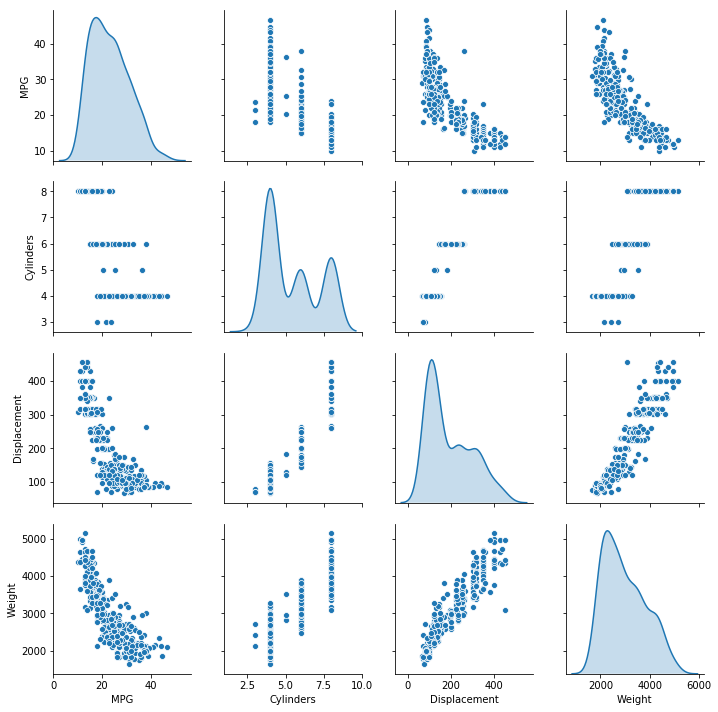

In [0]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

- This visualization shows that there is a somewhat linear relationshop between `Displacement` and `Weight`. 
- `MPG` seems to decrease with `Displacement` and `Weight` although this isn't linear.
- `Cylinders` do not vary continuously. Almost all of them have discrete values.
- `MPG` and `Weight` both have slightly positively skewed distributions. `Cylinders` are trimodal: most cars have either 3, 5, or 8 cylinders.

`pandas`' `describe` method can be used to get a quick look at statistical measures for all **numerical** columns in a dataset.

In [0]:
train_stats = train_dataset.describe()     # get statistics
train_stats.pop('MPG')                     # only input features, not MPG
train_stats = train_stats.transpose()      # Display stats along X axis for readability
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Step 6 - Extracting Labels/Outputs
The input features in the dataset are what we will be using to make predictions.

The output is the value we will be predicting. In this case, the value is `MPG`.

In [0]:
train_labels = train_dataset.pop('MPG')    # remove from training data
test_labels = test_dataset.pop('MPG')      # also remove from test dataset

## Step 7 - Normalize Data

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Reproduced verbatim because it's perfect.

In [0]:
def normalize(x):
  """A function that normalizes vector `x` using its mean and standard deviation"""
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

## Step 8 - Build the Model

In [0]:
def build_model():
  """Builds a densely connected, three-layer neural network with RMS
  prop method to minimize the loss function, which measures MSE
  between the actual and predicted value"""
  
  # Instantiate a Sequential keras NN
  # Layer 1 - one neuron per feature?
  # Layer 2 - hidden ayer
  # Layer 3 - only one neuron because a single output has to be predicted
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
  ])
  
  # Define an optimizer - the method the model will use to find optimal weights
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  # Compile the model with the initialized layers and optimizers - basically compute weights
  model.compile(loss='mean_squared_error', 
               optimizer=optimizer,        # keyword argument
               metrics = ['mean_absolute_error', 'mean_squared_error'])
  
  # Return a reference to this object
  return model

In [0]:
# Create this model
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
# Print the summary of the model - layers, total parameters, output shape
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Densely connected layers mean each node in one layer is connected to every node in the other layer. There is a weight term $w_{ij}$ that maps the input of a node from layer $i$ to a node in the next layer $j$. 

There is also a bias term for each connection. $b_{ij}$. 

So the total parameters to be computed per neuron?

$$ N =  1 \times b{i_j} + N \times w_{ij} = (N+1) $$

Since there are $$N$$ neurons per layer, the total number of parameters should be 
$$ N \times (N + 1)$$

In [0]:
len(train_dataset.keys())

9

Layer 1 has 9 features being fed into 64 neurons, so total params = $(9+1)(64) = 640$.

Layer 2 has 64 neurons, each connected to 64 other neurons, so total params = $(64 + 1)(64) = 4160$

## Step 8 - Does the model produce the right kind of output?

In [0]:
# Find the first ten training examples
example_batch = normed_train_data[:10]

# Compute the results for these features/examples
example_result = model.predict(example_batch)

# Echo the result
example_result

array([[-0.42289966],
       [-0.41236645],
       [-0.9622252 ],
       [-0.857056  ],
       [-0.7145502 ],
       [-0.3184412 ],
       [-0.72636986],
       [-1.1684237 ],
       [-0.22367302],
       [-0.53181237]], dtype=float32)

## Step 9 - Train the Model

### What in the name of all that is Holy is this?
We've created a class called `PrintDot` that (I think?) extends the `keras.callbacks.Callback` class. It has one method called `on_epoch_end` that takes two arguments: `epoch` and `logs`. Not sure what `logs` does, but the method basically prints a `.` for every training epoch (iteration) and outputs a new line at the end of every 100 dots. Otherwise, it prints a dot with no space at the end. 

We then define the number of training epochs as 1000 - this is a constant, hence the capital case. 

We then fit the model, passing it the normalized training features and outputs. We also specify the number of iterations (1000) we want to run this test for, and pass the `PrintDot()` function as a callback function - the function to be executed at the end of each successful epoch. 

`validation_split` defines the proportion of the training data that the fitting procedure is going to use to compute the output of the loss function. Instead of computing the difference between all training examples and their respective actual outputs, a quicker method is to compute the loss for a sample of the training data.

`verbose` is an argument that lets us specify if we want the method to output its complete  progress/details.

In [0]:
# Display the training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0 : print('')
    print('.', end='')
    
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels, 
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [0]:
# Visualize the model's training progress using the stats stored in te `history` object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.251047,0.970451,2.251047,7.904005,2.128983,7.904005,995
996,2.115563,0.911794,2.115562,8.041811,2.156287,8.041811,996
997,2.205480,0.921534,2.205480,8.640936,2.240759,8.640937,997
998,2.189811,0.914948,2.189811,7.527053,2.073005,7.527053,998
999,2.377117,0.969817,2.377117,7.106253,2.023571,7.106254,999


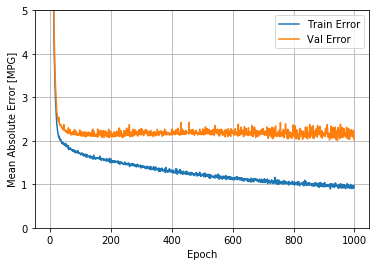

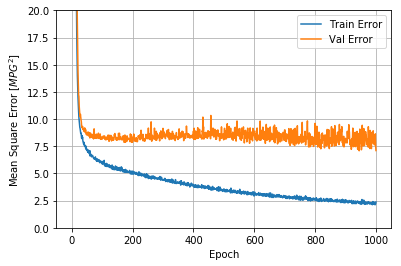

In [0]:
# Visualize the training performance history
def plot_history(history):
  hist = pd.DataFrame(history.history)   # DataFrame
  hist['epoch'] = history.epoch          # new column
  
  # Create a new MATLAB-style figure for mean absolute error
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.grid(True)
  
  # Create a new MATLAB-style figure for mean squared error
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'], 
          label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'], 
          label='Val Error')
  plt.ylim([0, 20])
  plt.legend()
  plt.grid(True)
  
# Call the function
plot_history(history)

In both cases, the training error decreases substantially with epoch count. However, the test error stays roughly constant and decreases only slightly with the epoch count. 


.............................................................

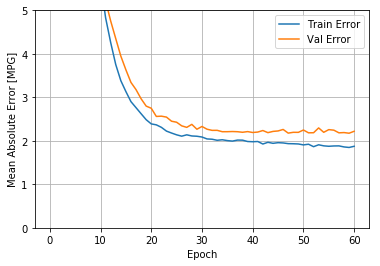

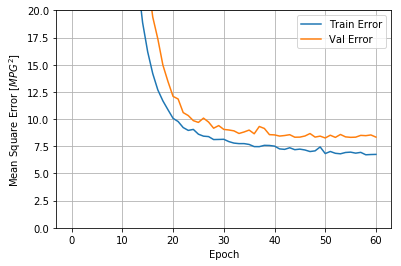

In [0]:
# Build the model again, but this time we'll stop training if the 
# error does not decrease substantially/increases after a smaller
# subset of epochs
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Get the training history
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# Plot it
plot_history(history)

### Interpretation
 - Instead of training for 1000 epochs, we limited ourselves to training for only 60 epochs.
 - This is because we passed an additional callback function to the model during `fit` - the `patience` function which will stop further iterations if the error has not decreased substantially compared to the previous epoch.
 - For our data, the error rate in both training data and the validation set (**not** the same as the test set) stabilized at 60 epochs.
 - So early stopping can be used to efficiently train neural networks.
 - Again, the training error rate is always lower than the validation set error rate.

## Step 10 - Making Predictions
Now we can use the neural network model we have trained to make predictions on the test set - values that it has never seen before during training.

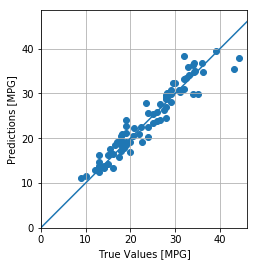

In [0]:
# Create a 1D array of predicted MPG values for test set
test_predictions = model.predict(normed_test_data).flatten()

# Plot the results on a scatter plot
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]'); plt.ylabel('Predictions [MPG]');
plt.axis('equal'); plt.axis('square');    # help visualize linear map
plt.xlim([0, plt.xlim()[1]])   # from 0 to default xlimit value 
plt.ylim([0, plt.ylim()[1]])   # from 0 to default ylimit value

# plot a straight line so that we can assess similarity b/w predicted and true vals
_= plt.plot([-100, 100], [-100, 100])
plt.grid(True)


### Interpretation
There seems to be a very good linear mapping between true values of MPG and predicted values generated by our neural network. This indicates that our neural network has performed quite wel. 

## Step 11 - Error Distribution

Text(0, 0.5, 'Frequency/Count')

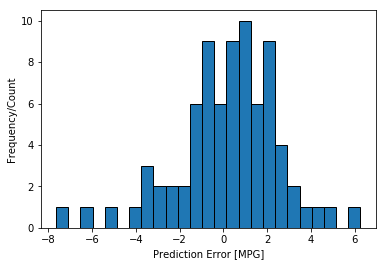

In [0]:
# Simple difference between predicted and actual MPG for each example in test set
error = test_predictions - test_labels

# Create a histogram to visualize frequency distribution of errors
plt.hist(error, bins=25, edgecolor='black')

plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Frequency/Count")

Not exactly normally distributed. Negatively skewed. But this is most likely because there aren't a lot of training examples.

## Conclusions

**Reproduced verbatim from the tutorial because v good**

This notebook introduced a few techniques to handle a regression problem.

- Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent overfitting.